<a href="https://colab.research.google.com/github/marc26farah/CSAT-Free-LLM-Case/blob/main/camembert_pipeline_CSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT Fine-tuning Pipeline Three Classes (French Sentiment / Classification)


## 0) Install dependencies

In [8]:

!pip install --upgrade pip
!pip install torch transformers datasets evaluate accelerate scikit-learn pandas matplotlib

!pip install onnxruntime optimum


## 1) Load data from SQLite and preview

In [9]:
!pip install transformers datasets scikit-learn pandas

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import sqlite3
import pandas as pd
sqlite_path = "/content/drive/MyDrive/free_csat_llm_case/data/db.sqlite"
conn = sqlite3.connect(sqlite_path)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print('Tables found:', tables['name'].tolist())

for t in tables['name'].tolist():
    print('\n--- TABLE:', t)
    df = pd.read_sql(f"SELECT * FROM '{t}' LIMIT 10;".format(t=t), conn)
    print(df.head(10).to_markdown())
conn.close()


Tables found: ['csat_extract']

--- TABLE: csat_extract
|    |   contact_id |   id_profil |   id_conseiller | date_contact   |   csat |   nps | nom_departement   | nom_region   | du_societe_label   | canal   | offer_label                                       | commentaire                                                                                                                                                                                                                                                                                                                                                        |
|---:|-------------:|------------:|----------------:|:---------------|-------:|------:|:------------------|:-------------|:-------------------|:--------|:--------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 2) Prepare dataset (convert to CSV / standardize columns)

In [12]:
# Example: load full table into a DataFrame (adjust table name)
import sqlite3, pandas as pd
conn = sqlite3.connect(sqlite_path)
# pick the first table detected by the DB for demonstration
table_name = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'].iloc[0]
df = pd.read_sql(f"SELECT * FROM '{table_name}';", conn)
print('Loaded table:', table_name, 'with shape', df.shape)
display(df.head())
# Save to CSV for the pipeline
df.to_csv('dataset_from_sqlite.csv', index=False)
conn.close()


Loaded table: csat_extract with shape (38303, 12)


,contact_id,id_profil,id_conseiller,date_contact,csat,nps,nom_departement,nom_region,du_societe_label,canal,offer_label,commentaire
0,49391456,20596135,135088.0,2025-10-19,3,6,\N,\N,\N,None,24: Freebox Pop | 39.99€,on donne toutes les infos à l’engagement et im...
1,49390924,15350417,135088.0,2025-10-19,4,7,\N,\N,\N,None,09: Freebox Révolution Light | 29.99€,"Saisi du Rio pas claire. Minuscule, pas Minusc..."
2,49390481,75269147,135088.0,2025-10-19,5,8,\N,\N,\N,None,28: Série Spéciale Freebox Pop S | 23.99€,Il manque la possibilité de choisir une date d...
3,49389164,24194380,135088.0,2025-10-19,5,9,\N,\N,\N,None,24: Freebox Pop | 39.99€,MERCI
4,49389166,48737310,135088.0,2025-10-19,4,8,\N,\N,\N,None,24: Freebox Pop | 39.99€,Il manque peut-être des précisions sur la pris...


## 3) Basic preprocessing

In [13]:
# basic cleaning and label normalization
import pandas as pd
df = pd.read_csv('dataset_from_sqlite.csv')
# inspecting columns
print('Columns:', df.columns.tolist())
# Heuristic: find text and label columns by common names
text_col = None
label_col = None
# for c in df.columns:
#     cl = c.lower()
#     if 'text' in cl or 'content' in cl or 'review' in cl:
#         text_col = c
#     if 'label' in cl or 'sentiment' in cl or 'target' in cl or 'class' in cl:
#         label_col = c
# print('Detected text column:', text_col, 'label column:', label_col)

text_col = 'commentaire'
label_col = 'csat'

if text_col not in df.columns:
    raise ValueError(f"Text column '{text_col}' not found in DataFrame.")
if label_col not in df.columns:
    raise ValueError(f"Label column '{label_col}' not found in DataFrame.")

df = df.dropna(subset=[text_col, label_col])
# simple normalization (strip)
df[text_col] = df[text_col].astype(str).str.strip()
df[label_col] = df[label_col].astype(str).str.strip() # Keep csat as string for now to map later

# mapping labels if needed:
label_mapping = {lab:i for i,lab in enumerate(sorted(df[label_col].unique()))}
print('Label mapping:', label_mapping)
df['label'] = df[label_col].map(label_mapping)
df[['label', text_col]].head()

Columns: ['contact_id', 'id_profil', 'id_conseiller', 'date_contact', 'csat', 'nps', 'nom_departement', 'nom_region', 'du_societe_label', 'canal', 'offer_label', 'commentaire']
Label mapping: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}


,label,commentaire
0,2,on donne toutes les infos à l’engagement et im...
1,3,"Saisi du Rio pas claire. Minuscule, pas Minusc..."
2,4,Il manque la possibilité de choisir une date d...
3,4,MERCI
4,3,Il manque peut-être des précisions sur la pris...


In [14]:
import pandas as pd

# loading dataset
df = pd.read_csv("/content/dataset_from_sqlite.csv")

# showing column names to verify
print("Columns in dataset:", df.columns.tolist())

# in case we still have numeric CSAT values:
if 'csat' in df.columns:
    print("\nUnique CSAT values and counts:")
    print(df['csat'].value_counts().sort_index())


if 'label' in df.columns:
    print("\nUnique sentiment classes and counts:")
    print(df['label'].value_counts().sort_index())

# in case there’s a textual sentiment column
for col in ['pred_label', 'sentiment']:
    if col in df.columns:
        print(f"\nUnique values in '{col}':")
        print(df[col].value_counts())


Columns in dataset: ['contact_id', 'id_profil', 'id_conseiller', 'date_contact', 'csat', 'nps', 'nom_departement', 'nom_region', 'du_societe_label', 'canal', 'offer_label', 'commentaire']

Unique CSAT values and counts:
csat
1     5908
2     1039
3     1646
4     3665
5    26045
Name: count, dtype: int64


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# loading dataset
df = pd.read_csv("/content/dataset_from_sqlite.csv")[['commentaire', 'csat']].dropna()

# converting CSAT (1–5) → 3 sentiment labels
def convert_label(x):
    if x <= 2: return 0       # Negative
    if x == 3: return 1       # Neutral
    return 2                  # Positive

df['label'] = df['csat'].apply(convert_label)

print(df['label'].value_counts())


label
2    29709
0     6947
1     1646
Name: count, dtype: int64


In [16]:
from sklearn.utils import resample

# splitting by classes
neg = df[df.label == 0]
neu = df[df.label == 1]
pos = df[df.label == 2]

# undersampling majority (positive) to match mid-class size
min_count = min(len(neg), len(pos))
pos_down = resample(pos, replace=False, n_samples=len(neg), random_state=42)
neu_up = resample(neu, replace=True, n_samples=len(neg), random_state=42)

# combining and shuffling
df_balanced = pd.concat([neg, neu_up, pos_down]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())


label
2    6947
1    6947
0    6947
Name: count, dtype: int64


In [17]:
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['label'],
    random_state=42
)


## 4) Tokenize and create Hugging Face dataset

In [18]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("camembert-base")

def tokenize(batch):
    return tokenizer(
        batch['commentaire'],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_ds = train_ds.with_format("torch", columns=['input_ids', 'attention_mask', 'label'])
test_ds  = test_ds.with_format("torch", columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Map:   0%|          | 0/16672 [00:00<?, ? examples/s]

Map:   0%|          | 0/4169 [00:00<?, ? examples/s]

## 5) Fine-tune CamemBERT

In [19]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=3)

training_args = TrainingArguments(
    output_dir="./camembert-balanced-results",
    eval_strategy="epoch", # Corrected argument name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
)

trainer.train()

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4267142026.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marc-farah-02 (marc-farah-02-ecole-polytechnique) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.664900,0.614195
2,0.500500,0.531080
3,0.377800,0.467095
4,0.292600,0.553079
5,0.230500,0.502387


TrainOutput(global_step=5210, training_loss=0.42916849249841615, metrics={'train_runtime': 967.4354, 'train_samples_per_second': 86.166, 'train_steps_per_second': 5.385, 'total_flos': 1.096656725090304e+16, 'train_loss': 0.42916849249841615, 'epoch': 5.0})

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

preds = trainer.predict(test_ds)
y_true = np.array(test_df['label'])
y_pred = preds.predictions.argmax(axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.8647157591748621

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1389
           1       0.82      0.92      0.87      1390
           2       0.90      0.85      0.88      1390

    accuracy                           0.86      4169
   macro avg       0.87      0.86      0.86      4169
weighted avg       0.87      0.86      0.86      4169


Confusion Matrix:
 [[1133  179   77]
 [  54 1284   52]
 [  95  107 1188]]


## 7) Save model and tokenizer

In [21]:
model.save_pretrained("/content/camembert_sentiment_balanced_model")
tokenizer.save_pretrained("/content/camembert_sentiment_balanced_model")


('/content/camembert_sentiment_balanced_model/tokenizer_config.json',
 '/content/camembert_sentiment_balanced_model/special_tokens_map.json',
 '/content/camembert_sentiment_balanced_model/sentencepiece.bpe.model',
 '/content/camembert_sentiment_balanced_model/added_tokens.json',
 '/content/camembert_sentiment_balanced_model/tokenizer.json')

## 8) Plots

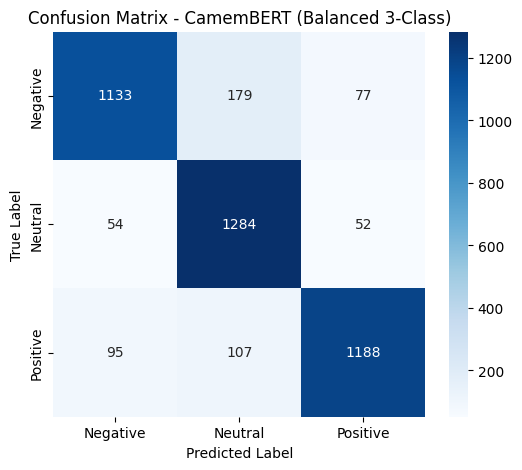

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - CamemBERT (Balanced 3-Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


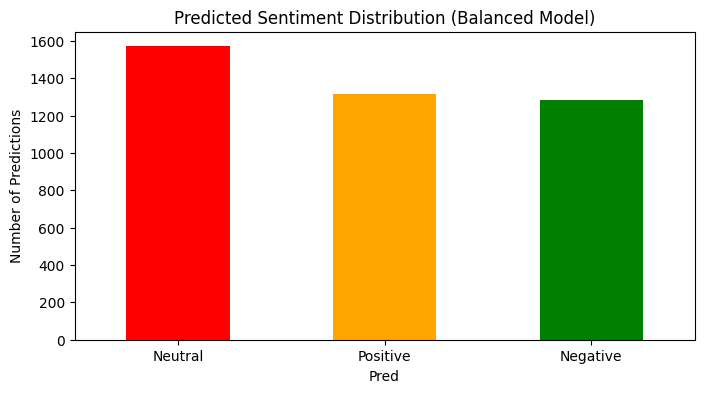


Predicted class distribution:
Pred
Neutral     1570
Positive    1317
Negative    1282
Name: count, dtype: int64


In [23]:
import numpy as np
import pandas as pd

#converting predictions to DataFrame for easy plotting
df_eval = pd.DataFrame({"True": y_true, "Pred": y_pred})

#label mapping
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_eval["True"] = df_eval["True"].map(label_map)
df_eval["Pred"] = df_eval["Pred"].map(label_map)

#plotting predicted vs actual distribution
plt.figure(figsize=(8,4))
df_eval["Pred"].value_counts().plot(kind="bar", color=["red","orange","green"])
plt.title("Predicted Sentiment Distribution (Balanced Model)")
plt.ylabel("Number of Predictions")
plt.xticks(rotation=0)
plt.show()

print("\nPredicted class distribution:")
print(df_eval["Pred"].value_counts())


# CamemBERT Fine-tuning Pipeline Four Classes (French Sentiment / Classification)


In [24]:
# FULL PIPELINE — 4-CLASS SENTIMENT SYSTEM
# Negative / Neutral / Positive / Mixed-Positive
# Model: CamemBERT

import pandas as pd
import numpy as np
import re

# Step 1 — Load dataset
df = pd.read_csv("/content/dataset_from_sqlite.csv")
print("Loaded:", df.shape)

df = df[['commentaire', 'csat']].dropna()
df['commentaire'] = df['commentaire'].astype(str).str.strip()
df['csat'] = df['csat'].astype(int)
print("After cleaning:", df.shape)


# Step 2 — Detect complaints (for Mixed label)
issue_keywords = [
    "problème","panne","erreur","bug","difficulté","réclamation","blocage",
    "déconnecte","lent","coupure","défaillance","mauvais","impossible","gênant"
]

def contains_issue(text):
    text = text.lower()
    return any(k in text for k in issue_keywords)

df['has_issue'] = df['commentaire'].apply(contains_issue)


# Step 3 — Create 4 sentiment labels
def assign_sentiment(row):
    s = row['csat']
    issue = row['has_issue']

    if s <= 2:
        return 0  # Negative
    if s == 3:
        return 1  # Neutral
    if s >= 4 and issue:
        return 3  # Mixed Positive
    return 2  # Positive

df['label'] = df.apply(assign_sentiment, axis=1)

print("Label distribution:")
print(df['label'].value_counts())


# Step 4 — Balance dataset
from sklearn.utils import resample

neg = df[df.label == 0]
neu = df[df.label == 1]
pos = df[df.label == 2]
mix = df[df.label == 3]

min_size = min(len(neg), len(neu), len(pos), len(mix))

neg = resample(neg, replace=False, n_samples=min_size, random_state=42)
neu = resample(neu, replace=False, n_samples=min_size, random_state=42)
pos = resample(pos, replace=False, n_samples=min_size, random_state=42)
mix = resample(mix, replace=False, n_samples=min_size, random_state=42)

df_balanced = pd.concat([neg, neu, pos, mix]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced classes:")
print(df_balanced['label'].value_counts())


# Step 5 — Train/Test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['label'],
    random_state=42
)

print("Train/Test sizes:")
print(train_df.shape, test_df.shape)


# Step 6 — Tokenize for CamemBERT
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("camembert-base")

def tokenize(batch):
    return tokenizer(
        batch['commentaire'],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_ds = train_ds.with_format("torch", columns=['input_ids','attention_mask','label'])
test_ds  = test_ds.with_format("torch", columns=['input_ids','attention_mask','label'])


# Step 7 — Model Training
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=4)

training_args = TrainingArguments(
    output_dir="./camembert-4class-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    warmup_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
)

print("Training started...")
trainer.train()


# Step 8 — Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

preds = trainer.predict(test_ds)
y_true = np.array(test_df['label'])
y_pred = preds.predictions.argmax(axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(
    y_true, y_pred,
    target_names=["Negative","Neutral","Positive","Mixed Positive"]
))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


# Step 9 — Save model
model.save_pretrained("/content/camembert_sentiment_4class")
tokenizer.save_pretrained("/content/camembert_sentiment_4class")
print("Model saved to /content/camembert_sentiment_4class")


# Step 10 — Inference function
def predict_sentiment(text):
    import torch
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    tokens = {key: value.to(model.device) for key, value in tokens.items()}
    outputs = model(**tokens)
    pred = torch.argmax(outputs.logits).item()

    label_map = {
        0: "Negative",
        1: "Neutral",
        2: "Positive",
        3: "Mixed Positive"
    }

    pos_words = ["merci", "rapide", "super", "parfait", "bien", "satisfait"]
    if pred == 2 and contains_issue(text):
        pred = 3

    return label_map[pred]

print("\nTest predictions:")
print("1.", predict_sentiment("problème résolu rapidement"))
print("2.", predict_sentiment("aucun souci, merci"))
print("3.", predict_sentiment("panne internet pendant 2 jours"))


Loaded: (38303, 12)
After cleaning: (38302, 2)
Label distribution:
label
2    25398
0     6947
3     4311
1     1646
Name: count, dtype: int64
Balanced classes:
label
0    1646
1    1646
2    1646
3    1646
Name: count, dtype: int64
Train/Test sizes:
(5267, 4) (1317, 4)


Map:   0%|          | 0/5267 [00:00<?, ? examples/s]

Map:   0%|          | 0/1317 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-135491183.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started...


Epoch,Training Loss,Validation Loss
1,No log,1.211524
2,1.273400,0.890968
3,1.273400,0.832415
4,0.893200,0.797365
5,0.711500,0.775721
6,0.711500,0.804311
7,0.583100,0.808189
8,0.488600,0.832761
9,0.488600,0.851637
10,0.429400,0.855588


Accuracy: 0.683371298405467

Classification Report:
                 precision    recall  f1-score   support

      Negative       0.64      0.67      0.65       329
       Neutral       0.46      0.44      0.45       329
      Positive       0.85      0.86      0.85       330
Mixed Positive       0.79      0.76      0.77       329

      accuracy                           0.68      1317
     macro avg       0.68      0.68      0.68      1317
  weighted avg       0.68      0.68      0.68      1317


Confusion Matrix:
 [[222  81  13  13]
 [100 145  35  49]
 [ 13  28 283   6]
 [ 14  62   3 250]]
Model saved to /content/camembert_sentiment_4class

Test predictions:
1. Mixed Positive
2. Positive
3. Neutral
